# Opioid distribution in California

This notebook documents the Los Angeles Times' analysis of U.S. Drug Enforcement Agency data released by The Washington Post in July 2019 as part of an [investigation of opioids distribution](https://www.washingtonpost.com/graphics/2019/investigations/dea-pain-pill-database/?utm_term=.9717a00308fe) nationwide. The data, pulled from the agency's Automation of Reports and Consolidated Order System, known as ARCOS, show prescription pain pill transactions from manufacurers to distributors from 2006 to 2012. During that time, more than 8 billion tablets of hydrocodone and oxycodone were distributed to California.

### To begin, load python libraries and set config params

In [470]:
import pandas as pd
import psycopg2 as pg
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
import sqlalchemy
import pandas.io.sql as psql
import numpy as np
import geopandas 
import descartes
import geojson
import scheme
import mapclassify

plt.rcParams['figure.figsize'] = (20, 10)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sorted(mpl.style.available)

['Solarize_Light2',
 '_classic_test',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

### Connect to the local posgres server with California data

In [466]:
database = pg.connect("dbname=opioids user=postgres")

### Query database to create dataframe for analysis with python and pandas

In [22]:
pillssql = psql.read_sql("SELECT transaction_date, buyer_dea_no, buyer_bus_act, buyer_name, buyer_city, buyer_zip, buyer_county, drug_name, quantity, (case when length(dosage_unit) > 1 then dosage_unit end) as dosage_unit, mme_conversion_factor FROM opioidsca", database)

### To speed things up, try reading the from a tsv, not postgres

In [23]:
pills = pd.read_csv("/Users/mhustiles/Desktop/data/arcos-ca-statewide-itemized.tsv", sep='\t', header=0, low_memory=False)

In [282]:
pop = pd.read_csv("/Users/mhustiles/Desktop/data/ca-counties-pop-1970-2050.csv", sep=',', header=0, low_memory=False)

### Read the tsv with proper data types: first on import — and then after

In [25]:
pills = pd.read_csv("/Users/mhustiles/Desktop/data/arcos-ca-statewide-itemized.tsv", sep='\t', header=0, low_memory=False, dtype={'BUYER_ZIP': 'str'})

In [26]:
pills['REPORTER_ZIP'] = pills.REPORTER_ZIP.astype(object)

In [27]:
pills['DRUG_CODE'] = pills.DRUG_CODE.astype(object)

### Transform the original int64 date field to a usable date

In [28]:
pills['TRANSACTION_DATE'] = pd.to_datetime(pills['TRANSACTION_DATE'].astype('str'), format = '%m%d%Y')

### Parse the date further to extact year and month in new fields

In [29]:
pills['TRANSACTION_DATE'] = pd.to_datetime(pills['TRANSACTION_DATE'])
pills['YEAR'], pills['MONTH'] = pills['TRANSACTION_DATE'].dt.year, pills['TRANSACTION_DATE'].dt.month

### Change month, year fields to objects for grouping

In [30]:
pills['YEAR'] = pills.YEAR.astype(object)

In [31]:
pills['MONTH'] = pills.MONTH.astype(object)

### A look at all the data types for each field in our data population frame

In [283]:
pop['year'] = pop.year.astype(object)
pop.dtypes

fips           int64
county        object
year          object
age            int64
pop_female     int64
pop_male       int64
pop_total      int64
dtype: object

### A look at all the data types for each field in our pills data frame

In [33]:
pills.dtypes

REPORTER_DEA_NO                  object
REPORTER_BUS_ACT                 object
REPORTER_NAME                    object
REPORTER_ADDL_CO_INFO            object
REPORTER_ADDRESS1                object
REPORTER_ADDRESS2                object
REPORTER_CITY                    object
REPORTER_STATE                   object
REPORTER_ZIP                     object
REPORTER_COUNTY                  object
BUYER_DEA_NO                     object
BUYER_BUS_ACT                    object
BUYER_NAME                       object
BUYER_ADDL_CO_INFO               object
BUYER_ADDRESS1                   object
BUYER_ADDRESS2                   object
BUYER_CITY                       object
BUYER_STATE                      object
BUYER_ZIP                        object
BUYER_COUNTY                     object
TRANSACTION_CODE                 object
DRUG_CODE                        object
NDC_NO                           object
DRUG_NAME                        object
QUANTITY                        float64


In [284]:
pop.head(6)

,fips,county,year,age,pop_female,pop_male,pop_total
0,6001,ALAMEDA,1970,0,8533,8671,17204
1,6001,ALAMEDA,1970,1,8151,8252,16403
2,6001,ALAMEDA,1970,2,7753,8015,15768
3,6001,ALAMEDA,1970,3,8018,8412,16430
4,6001,ALAMEDA,1970,4,8551,8648,17199
5,6001,ALAMEDA,1970,5,9012,9208,18220


In [292]:
popsum = pop.groupby(['year','county'], as_index=False).agg({"pop_total": "sum"})
popsum.head(6)

,year,county,pop_total
0,1970,ALAMEDA,1072985
1,1970,ALPINE,506
2,1970,AMADOR,11900
3,1970,BUTTE,102530
4,1970,CALAVERAS,13716
5,1970,COLUSA,12372


In [309]:
years = [2006,2007,2008,2009,2010,2011,2012]
popsumyears = pop[pop.year.isin(years)]
popsumyearsadults = popsumyears[popsumyears.age > 17]

In [335]:
adults = popsumyearsadults.groupby(['year','county'], as_index=False).agg({"pop_total": "sum"})

In [336]:
adults

,year,county,pop_total
0,2006,ALAMEDA,1112310
1,2006,ALPINE,996
2,2006,AMADOR,30667
3,2006,BUTTE,166403
4,2006,CALAVERAS,36225
5,2006,COLUSA,14646
6,2006,CONTRA COSTA,753146
7,2006,DEL NORTE,21967
8,2006,EL DORADO,133415
9,2006,FRESNO,610750


### How many people (should update to just adults) lived in each California county in each of the years from 2006 to 2012?

In [138]:
pillyears['county'] = pillyears['county'].astype(object)

In [139]:
pills['county'] = pills.BUYER_COUNTY.astype(object)

In [317]:
pillyears.head()

,year,county,pop_total
0,2006,ALAMEDA,1464841
1,2006,ALPINE,1249
2,2006,AMADOR,37962
3,2006,BUTTE,215679
4,2006,CALAVERAS,45318


### Merge our tables for pill by county and population by county

In [377]:
pillscounties = pills.groupby(['YEAR','BUYER_COUNTY'], as_index=False).agg({"DOSAGE_UNIT": "sum"})

In [378]:
pillyears['year'] = pillyears.year.astype(object)
pillscounties['year'] = pillscounties.YEAR.astype(object)
pillscounties['county'] = pillscounties.BUYER_COUNTY.astype(object)

In [379]:
merged = pd.merge(adults,pillscounties, on=['county','year'])

In [380]:
merged

,year,county,pop_total,YEAR,BUYER_COUNTY,DOSAGE_UNIT
0,2006,ALAMEDA,1112310,2006,ALAMEDA,66857939.5
1,2006,ALPINE,996,2006,ALPINE,100.0
2,2006,AMADOR,30667,2006,AMADOR,2056490.0
3,2006,BUTTE,166403,2006,BUTTE,13802710.0
4,2006,CALAVERAS,36225,2006,CALAVERAS,2085600.0
5,2006,COLUSA,14646,2006,COLUSA,604950.0
6,2006,CONTRA COSTA,753146,2006,CONTRA COSTA,25765626.0
7,2006,DEL NORTE,21967,2006,DEL NORTE,1825800.0
8,2006,EL DORADO,133415,2006,EL DORADO,6302178.0
9,2006,FRESNO,610750,2006,FRESNO,24354294.0


### Create a rate field in our merged table

In [381]:
merged['rate'] = (merged['DOSAGE_UNIT']/merged['pop_total']).round(5)

In [382]:
merged

,year,county,pop_total,YEAR,BUYER_COUNTY,DOSAGE_UNIT,rate
0,2006,ALAMEDA,1112310,2006,ALAMEDA,66857939.5,60.10729
1,2006,ALPINE,996,2006,ALPINE,100.0,0.10040
2,2006,AMADOR,30667,2006,AMADOR,2056490.0,67.05873
3,2006,BUTTE,166403,2006,BUTTE,13802710.0,82.94748
4,2006,CALAVERAS,36225,2006,CALAVERAS,2085600.0,57.57350
5,2006,COLUSA,14646,2006,COLUSA,604950.0,41.30479
6,2006,CONTRA COSTA,753146,2006,CONTRA COSTA,25765626.0,34.21067
7,2006,DEL NORTE,21967,2006,DEL NORTE,1825800.0,83.11558
8,2006,EL DORADO,133415,2006,EL DORADO,6302178.0,47.23740
9,2006,FRESNO,610750,2006,FRESNO,24354294.0,39.87604


### Save files

In [ ]:
merged.to_csv("/Users/mhustiles/Desktop/data/merged.csv", sep=',', encoding='utf-8')
merged.to_csv("/Users/mhustiles/Desktop/github/opioids/ca-county-pills-rate.csv", sep=',', encoding='utf-8')

### New merged table with county, drug, business type, pills, population and rate — sorted desc by rate
### (These places are the outliers)

In [ ]:
merged.sort_values(by='rate', ascending=False)

### How did the per-person rate of drug distribution change in SAN BERNARDINO over time? 

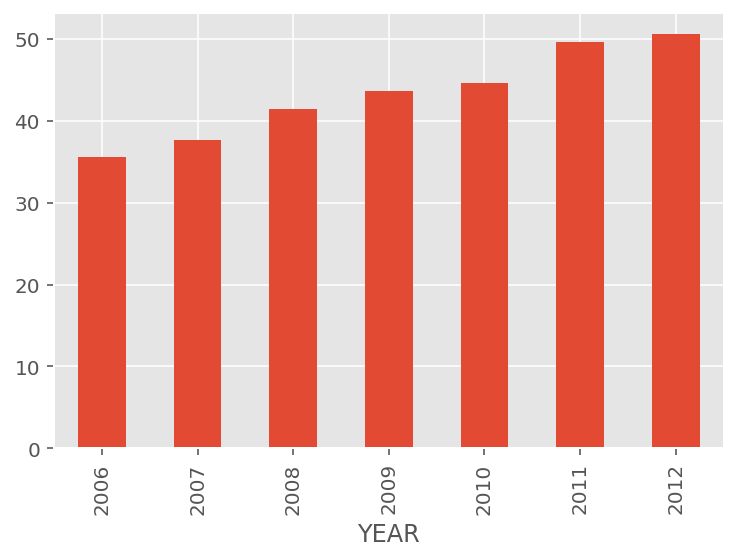

In [400]:
def doplot():
    merged[(merged.county == 'SAN BERNARDINO')].groupby(['YEAR'])[('rate')].mean().plot.bar(y='YEAR')

mpl.style.use('ggplot')
doplot()

### How did the per-person rate of drug distribution change STATEWIDE over time? 

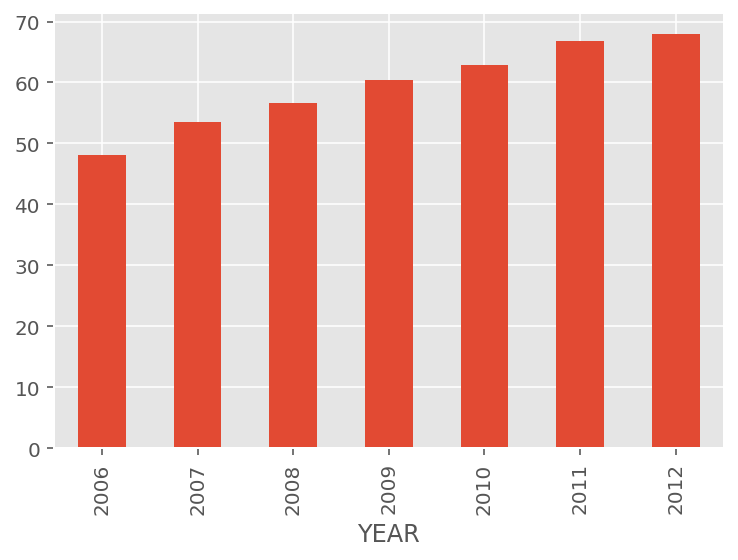

In [401]:
def doplot():
    merged.groupby(['YEAR'])[('rate')].mean().plot.bar(y='YEAR')

mpl.style.use('ggplot')
doplot()

### Who were the largest distributors in CA during the period?

### How does pill distribution in California compare, per capita, with other states?

### How does pill distribution in Los Angeles County compare, per capita, with other counties?

### Which CA cities had the highest per capita pill distribution?

### Oxy distribution to retail pharmacies in zipcode 90066 over time?

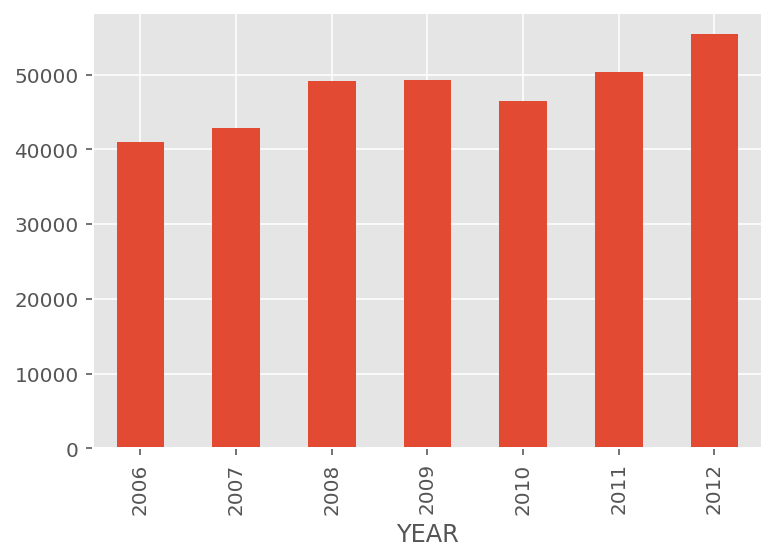

In [402]:
def doplot():
    pills[(pills.BUYER_ZIP == '90066') & (pills.DRUG_NAME == 'OXYCODONE') & (pills.BUYER_BUS_ACT == 'RETAIL PHARMACY')].groupby(['YEAR'])[('DOSAGE_UNIT')].sum().plot.bar(y='YEAR')
    
mpl.style.use('ggplot')
doplot()

In [187]:
map = geopandas.read_file('/Users/mhustiles/Desktop/data/GIS/ca-counties.geojson')

In [409]:
map['county'] = map.Name.str.upper()

In [411]:
map.head(3)

,CountyFIPS,FIPS,Name,geometry,county
0,059,06059,Orange,"(POLYGON ((-118.097404 33.77419, -118.097466 3...",ORANGE
1,103,06103,Tehama,"(POLYGON ((-122.199173 40.377943, -122.199127 ...",TEHAMA
2,011,06011,Colusa,"(POLYGON ((-122.256982 39.384842, -122.256879 ...",COLUSA


In [413]:
mapmerged = pd.merge(map,merged, on=['county'])

In [430]:
mapmerged.year.astype(object)
mapmerged.head(2)

,CountyFIPS,FIPS,Name,geometry,county,year,pop_total,YEAR,BUYER_COUNTY,DOSAGE_UNIT,rate
0,059,06059,Orange,"(POLYGON ((-118.097404 33.77419, -118.097466 3...",ORANGE,2006,2181492,2006,ORANGE,62873629.0,28.82139
1,059,06059,Orange,"(POLYGON ((-118.097404 33.77419, -118.097466 3...",ORANGE,2007,2198201,2007,ORANGE,63875605.5,29.05813


In [443]:
mapmerged2006 = mapmerged[mapmerged.year == 2006]
mapmerged2012 = mapmerged[mapmerged.year == 2012]

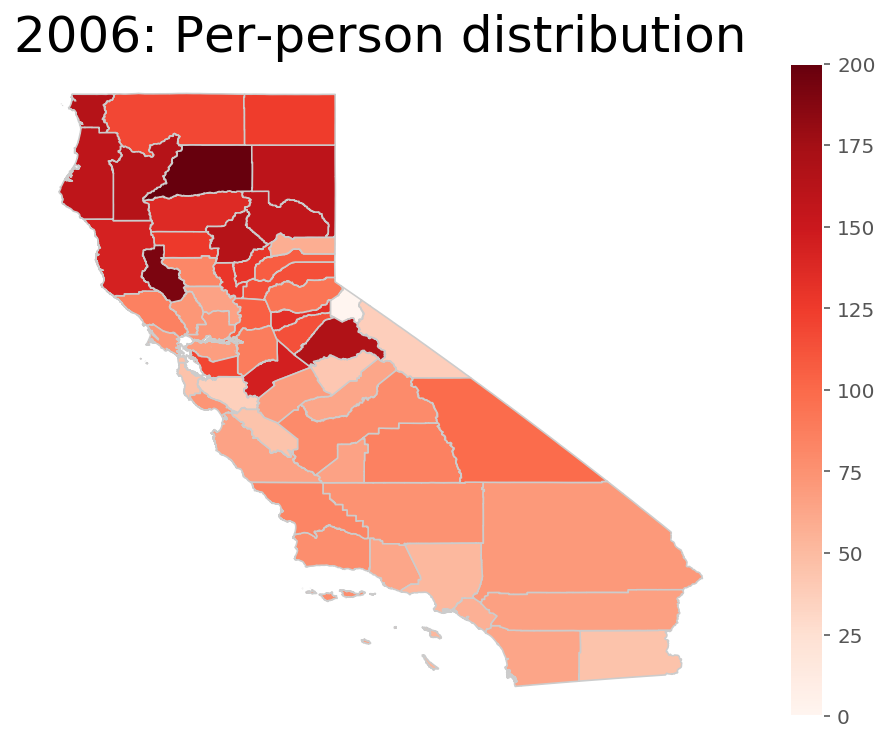

In [459]:
variable = 'rate'
vmin, vmax = 0, 200
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('2006: Per-person distribution', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
mapmerged2006.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

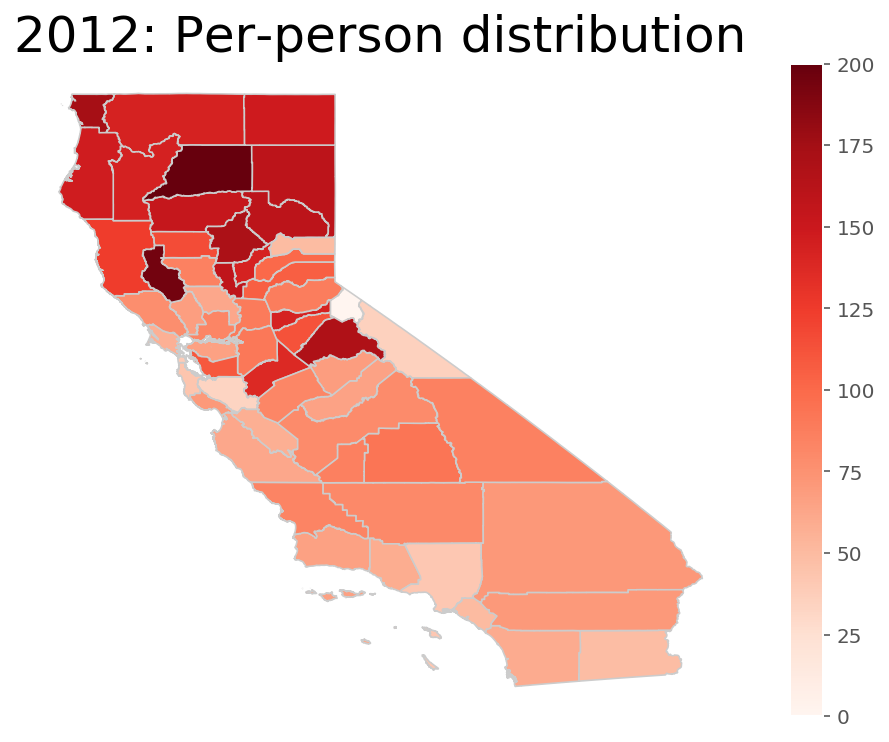

In [460]:
variable = 'rate'
vmin, vmax = 0, 200
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('2012: Per-person distribution', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
mapmerged2012.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

### Better maps with natural breaks

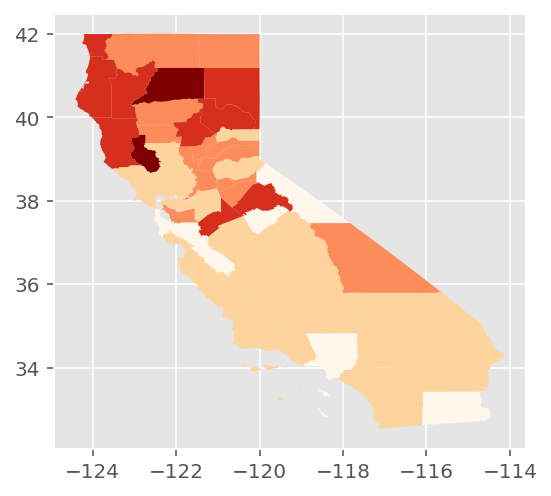

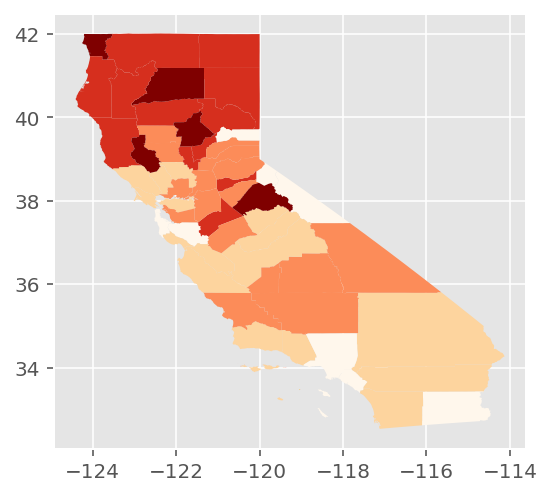

In [484]:
mapmerged2006.plot(column='rate', cmap='OrRd', scheme='natural_breaks')
mapmerged2012.plot(column='rate', cmap='OrRd', scheme='natural_breaks')